Stitching together some of Jiaxuan's code to ensure I'm reproducing the SBP's he found with Dragonfly

In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table
import h5py
import os
import numpy as np
import cosmology
from astropy.table import join

HSC_pixel_scale = 0.168
DECaLS_pixel_scale = 0.262
Dragonfly_pixel_scale = 2.5
SDSS_pixel_scale = 0.395
HSC_zeropoint = 27.0
DECaLS_zeropoint = 22.5
SDSS_zeropoint = 22.5
Dragonfly_zeropoint_g = 27.37635915911822 
Dragonfly_zeropoint_r = 27.10646046539894



In [2]:
jiaxuan_cat = Table.read("/Users/matt/Data/legacydata/jiaxuan_data/s16a_massive_z_0.5_logm_11.4_decals_full_fdfc_bsm_ell_decals_2021_07.fits")
sv3_cat = Table.read("/Users/matt/Data/legacydata/sv3-clustering/BGS_BRIGHT_S_clustering.dat.fits")

jiaxuan_cat.add_column(0, name="join_id")
sv3_cat.add_column(0, name="join_id")

In [3]:
from esutil import htm

matcher = htm.HTM()

sv3_ra = sv3_cat["RA"]
sv3_dec = sv3_cat["DEC"]

j_ra = jiaxuan_cat["ra"]
j_dec = jiaxuan_cat["dec"]

idx_sv3, idx_j, _ = matcher.match(sv3_ra, sv3_dec, j_ra, j_dec, 1.0/3600)

print(f"{len(idx_j)} Jiaxuan galaxies matches")
print(f"{len(idx_sv3)} SV3 galaxies matched")

matches = [
    (sv3_cat[x], jiaxuan_cat[y]) for x, y in zip(idx_sv3, idx_j)
]


386 Jiaxuan galaxies matches
386 SV3 galaxies matched


In [9]:
# Assign a unique ID to each matched row
unique_id = 1
for x, y in zip(idx_sv3, idx_j):
    sv3_cat[x]["join_id"] = unique_id
    jiaxuan_cat[y]["join_id"] = unique_id
    unique_id += 1

# Filter our table to only matched rows
sv3_matches = sv3_cat[sv3_cat["join_id"]>0]
jiaxuan_matches = jiaxuan_cat[jiaxuan_cat["join_id"]>0]

# Join on the unique ID for a combined table
combined_cat = join(sv3_matches, jiaxuan_matches, keys="join_id")
combined_cat.remove_column("ra")
combined_cat.remove_column("dec")

In [10]:
# QA check to ensure matched rows are accurate
for s, j in matches:
    this_row = combined_cat[combined_cat["TARGETID"]==s["TARGETID"]]
    assert this_row["id_s16a"] == j["id_s16a"]

In [14]:
from collections import defaultdict
dupes = defaultdict(list)
for col in combined_cat.colnames:
    dupes[col.lower()].append(col)

for k, v in dupes.items():
    if len(v) > 1:
        print(k, v)

print(combined_cat.colnames)

['RA', 'DEC', 'TARGETID', 'NTILE', 'TILES', 'Z', 'COMP_TILE', 'rosette_number', 'rosette_r', 'FRACZ_TILELOCID', 'BITWEIGHTS', 'PROB_OBS', 'WEIGHT_ZFAIL', 'WEIGHT', 'flux_g_dered', 'flux_r_dered', 'flux_z_dered', 'flux_w1_dered', 'flux_w2_dered', 'REST_GMR_0P1', 'KCORR_R0P1', 'KCORR_G0P1', 'KCORR_R0P0', 'KCORR_G0P0', 'REST_GMR_0P0', 'EQ_ALL_0P0', 'EQ_ALL_0P1', 'ABSMAG_R', 'NZ', 'WEIGHT_FKP', 'join_id', 'index', 'id_s16a', 'clean_photometry', 'z_spec', 'z_best', 'z_phot', 'z_type', 'gcmodel_mag', 'gcmodel_mag_err', 'rcmodel_mag', 'rcmodel_mag_err', 'icmodel_mag', 'icmodel_mag_err', 'zcmodel_mag', 'zcmodel_mag_err', 'ycmodel_mag', 'ycmodel_mag_err', 'MSTAR', 'lum_max', 'lum_150', 'lum_120', 'lum_100', 'lum_75', 'lum_50', 'lum_25', 'lum_10', 'lum_5', 'lum_15', 'lum_30', 'lum_40', 'lum_60', 'logm_5', 'logm_10', 'logm_15', 'logm_25', 'logm_30', 'logm_40', 'logm_50', 'logm_60', 'logm_75', 'logm_100', 'logm_120', 'logm_150', 'logm_max', 'photoz_err68_min', 'photoz_err68_max', 'vdisp_sdss', 'vd

In [13]:
combined_cat.write("/Users/matt/Data/legacydata/jiaxuan_data/sv3_matches.fits", overwrite=True)

In [6]:
data_path = '/Users/matt/Data/legacydata/sv3-clustering/raw_output/'
ellipse_nm = 'total_ellipse.fits'
tractor_nm = 'total_tractor.fits'
sample_nm = 'total_sample.fits'

sv3_ellipses = Table.read(os.path.join(data_path, ellipse_nm))

In [10]:
# ID_CENT == TARGETID
for sv3, j in matches:
    if sv3["TARGETID"] in sv3_ellipses["ID_CENT"]:
        print(sv3["TARGETID"], j["id_s16a"])

valid = [(39627788436636918, 41231990984312678), (39627806421813762, 42279121190946492)]

39627788436636918 41231990984312678
39627775635622238 41104439045554653
39627806421813762 42279121190946492
39627776201852193 41205873288173878


In [24]:
def phys_size_fn(redshift, is_print=True, H0=70, Omegam=0.3, Omegal=0.7):
    '''Calculate the corresponding physical size per arcsec of a given redshift
    in the Lambda-CDM cosmology.

    Requirement:
    -----------
    cosmology: https://github.com/esheldon/cosmology
    
    Parameters:
    -----------
    redshift: float
    is_print: boolean. If true, it will print out the physical scale at the given redshift.
    Omegam: float, density parameter of matter. It should be within [0, 1]. 
    Omegal: float, density parameter of Lambda.

    Returns:
    -----------
    physical_size: float, in 'kpc/arcsec'
    '''
    cosmos = cosmology.Cosmo(H0=H0, omega_m=Omegam, flat=True, omega_l=Omegal, omega_k=None)
    ang_distance = cosmos.Da(0.0, redshift)
    physical_size = ang_distance/206265*1000 # kpc/arcsec
    if is_print:
        print ('At redshift', redshift, ', 1 arcsec =', physical_size, 'kpc')
    return physical_size

In [25]:
# You can plot 1-D SBP using this, without plotting the PA and eccentricity.
def SBP_single(ell_fix, redshift, pixel_scale, zeropoint, ax=None, offset=0.0, 
    x_min=1.0, x_max=4.0, alpha=1, physical_unit=False, show_dots=False, show_grid=False, 
    show_banner=True, vertical_line=None, linecolor='firebrick', linestyle='-', 
    linewidth=3, labelsize=25, ticksize=30, label='SBP', labelloc='lower left'):

    """Display the 1-D profiles, without showing PA and ellipticity.
    
    Parameters:
    -----------
    ell_fix: astropy Table or numpy table, should be the output of ELLIPSE.
    redshift: float, redshift of the object.
    pixel_scale: float, pixel scale in arcsec/pixel.
    zeropoint: float, zeropoint of the photometry system.
    ax: matplotlib axes class.
    offset: float.
    x_min, x_max: float, in ^{1/4} scale.
    alpha: float, transparency.
    physical_unit: boolean. If true, the figure will be shown in physical scale.
    show_dots: boolean. If true, it will show all the data points.
    show_grid: boolean. If true, it will show a grid.
    vertical_line: list of floats, positions of vertical lines. Maximum length is three.
    linecolor, linestyle: string. Color and style of SBP.
    label: string.

    Returns:
    --------
    ax: matplotlib axes class.

    """
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.0, right=1.0, 
                            bottom=0.0, top=1.0,
                            wspace=0.00, hspace=0.00)

        ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.88])
        ax1.tick_params(direction='in')
    else:
        ax1 = ax
        ax1.tick_params(direction='in')

    # Calculate physical size at this redshift
    phys_size = phys_size_fn(redshift, is_print=False)

    # 1-D profile
    if 'intens_err' in ell_fix.colnames:
        intens_err_name = 'intens_err'
    else:
        intens_err_name = 'int_err'

    if physical_unit is True:
        x = ell_fix['sma'] * pixel_scale * phys_size
        y = -2.5 * np.log10((ell_fix['intens'].data + offset) / (pixel_scale)**2) + zeropoint
        y_upper = -2.5 * np.log10((ell_fix['intens'] + offset + ell_fix[intens_err_name]) / (pixel_scale)**2) + zeropoint
        y_lower = -2.5 * np.log10((ell_fix['intens'] + offset - ell_fix[intens_err_name]) / (pixel_scale)**2) + zeropoint
        upper_yerr = y_lower - y
        lower_yerr = y - y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{kpc})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
    else:
        x = ell_fix['sma'] * pixel_scale
        y = -2.5 * np.log10((ell_fix['intens'].data + offset) / (pixel_scale)**2) + zeropoint
        y_upper = -2.5 * np.log10((ell_fix['intens'] + offset + ell_fix[intens_err_name]) / (pixel_scale) ** 2) + zeropoint
        y_lower = -2.5 * np.log10((ell_fix['intens'] + offset - ell_fix[intens_err_name]) / (pixel_scale) ** 2) + zeropoint
        upper_yerr = y_lower - y
        lower_yerr = y - y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{arcsec})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
    
    # If `nan` at somewhere, interpolate `nan`.
    if show_grid:
        ax1.grid(linestyle='--', alpha=0.4, linewidth=2)
    if show_dots:
        ax1.errorbar((x ** 0.25), y,
                 yerr=asymmetric_error,
                 color='k', alpha=0.2, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)

    if label is not None:
        ax1.plot(x**0.25, y, color=linecolor, linewidth=linewidth, linestyle=linestyle,
             label=r'$\mathrm{' + label + '}$', alpha=alpha)
        leg = ax1.legend(fontsize=labelsize, frameon=False, loc=labelloc)
        for l in leg.legendHandles:
            l.set_alpha(1)
    else:
        ax1.plot(x**0.25, y, color=linecolor, linewidth=linewidth, linestyle=linestyle, alpha=alpha)
    ax1.fill_between(x**0.25, y_upper, y_lower, color=linecolor, alpha=0.3*alpha, label=None)
    
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize)

    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(xlabel, fontsize=ticksize)
    ax1.set_ylabel(ylabel, fontsize=ticksize)
    ax1.invert_yaxis()

    # Twin axis with linear scale
    if physical_unit and show_banner is True:
        ax4 = ax1.twiny() 
        ax4.tick_params(direction='in')
        lin_label = [1, 2, 5, 10, 50, 100, 150, 300]
        lin_pos = [i**0.25 for i in lin_label]
        ax4.set_xticks(lin_pos)
        ax4.set_xlim(ax1.get_xlim())
        ax4.set_xlabel(r'$\mathrm{kpc}$', fontsize=ticksize)
        ax4.xaxis.set_label_coords(1, 1.025)

        ax4.set_xticklabels([r'$\mathrm{'+str(i)+'}$' for i in lin_label], fontsize=ticksize)
        for tick in ax4.xaxis.get_major_ticks():
            tick.label.set_fontsize(ticksize)

    plt.sca(ax1)
    
    # Vertical line
    if vertical_line is not None:
        if len(vertical_line) > 3:
            raise ValueError('Maximum length of vertical_line is 3.') 
        ylim = ax1.get_ylim()
        style_list = ['-', '--', '-.']
        for k, pos in enumerate(vertical_line):
            ax1.axvline(x=pos**0.25, ymin=0, ymax=1,
                        color='gray', linestyle=style_list[k], linewidth=3, alpha=0.75)
        plt.ylim(ylim)

    # Return
    if ax is None:
        return fig
    return ax1

In [26]:
valid = [(39627788436636918, 41231990984312678), (39627806421813762, 42279121190946492)]

In [40]:
print(sv3.colnames)

['RA', 'DEC', 'TARGETID', 'NTILE', 'TILES', 'Z', 'COMP_TILE', 'rosette_number', 'rosette_r', 'FRACZ_TILELOCID', 'BITWEIGHTS', 'PROB_OBS', 'WEIGHT_ZFAIL', 'WEIGHT', 'flux_g_dered', 'flux_r_dered', 'flux_z_dered', 'flux_w1_dered', 'flux_w2_dered', 'REST_GMR_0P1', 'KCORR_R0P1', 'KCORR_G0P1', 'KCORR_R0P0', 'KCORR_G0P0', 'REST_GMR_0P0', 'EQ_ALL_0P0', 'EQ_ALL_0P1', 'ABSMAG_R', 'NZ', 'WEIGHT_FKP']


2
/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/IntermediateZ/DECaLS-data-2021-07/4227/42279121190946492/42279121190946492-custom-42279121190946492-ellipse.fits


/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_81130/874435152.py:54: RuntimeWarning: invalid value encountered in log10
  y = -2.5 * np.log10((ell_fix['intens'].data + offset) / (pixel_scale)**2) + zeropoint
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_81130/874435152.py:56: RuntimeWarning: invalid value encountered in log10
  y_lower = -2.5 * np.log10((ell_fix['intens'] + offset - ell_fix[intens_err_name]) / (pixel_scale)**2) + zeropoint
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_81130/874435152.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_81130/874435152.py:93: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(ticksize)


/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/IntermediateZ/DECaLS-data-2021-07/4123/41231990984312678/41231990984312678-custom-41231990984312678-ellipse.fits


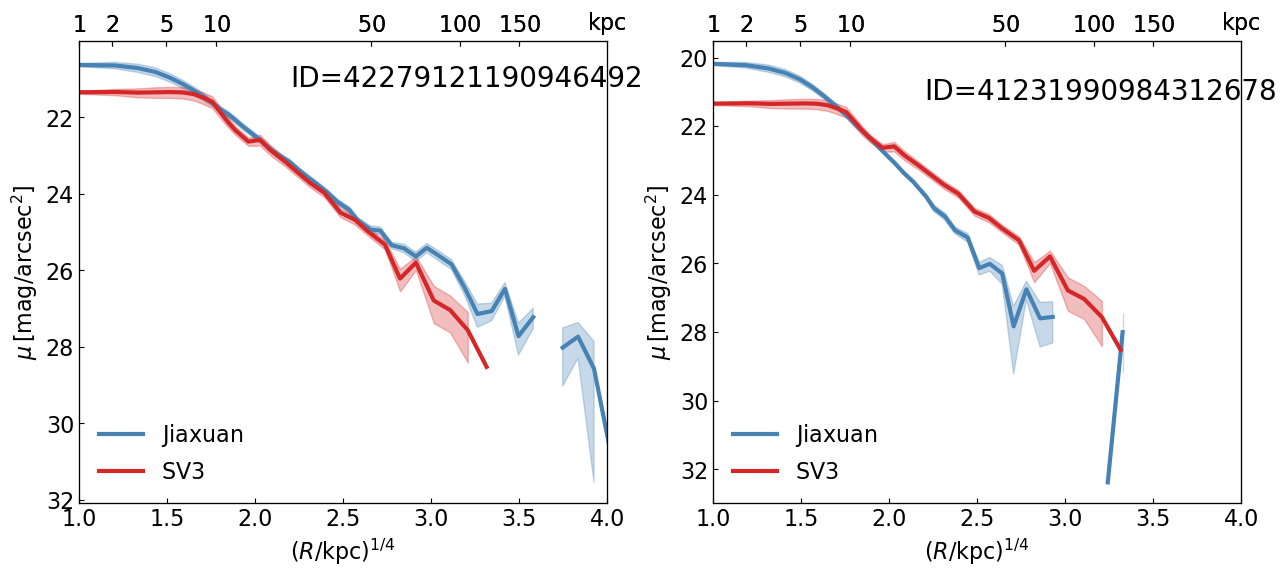

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

filtered_cat = jiaxuan_cat[np.isin(jiaxuan_cat["id_s16a"], [41231990984312678, 42279121190946492])]
print(len(filtered_cat))

for i, obj in enumerate(filtered_cat):
        
    print(obj['decals_dir'])
    if obj["id_s16a"] == 42279121190946492:
        ellipsefit_j = Table.read("/Users/matt/Data/legacydata/jiaxuan_data/DECaLS-data-2021-07/4227/42279121190946492/42279121190946492-custom-42279121190946492-ellipse.fits")
        ellipsefit_sv3 = sv3_ellipses[sv3_ellipses["ID_CENT"] == 39627806421813762]
        sv3_z = sv3_cat[sv3_cat["TARGETID"] == 39627806421813762]["Z"]
    else:
        ellipsefit_j = Table.read("/Users/matt/Data/legacydata/jiaxuan_data/DECaLS-data-2021-07/4123/41231990984312678/41231990984312678-custom-41231990984312678-ellipse.fits")
        ellipsefit_sv3 = sv3_ellipses[sv3_ellipses["ID_CENT"] == 39627806421813762]
        sv3_z = sv3_cat[sv3_cat["TARGETID"] == 39627806421813762]["Z"]
    ax = axes[i]

    
    ell_decals = Table(
        data=[
            ellipsefit_j['R_SMA'].data[0],  # pixel
            ellipsefit_j['R_INTENS'].data[0] * (DECaLS_pixel_scale)**
            2,  # nanomaggie/pixel
            ellipsefit_j['R_INTENS_ERR'].data[0] * (DECaLS_pixel_scale)**
            2  # nanomaggie/pixel
        ],
        names=['sma', 'intens', 'intens_err'])

    ax=SBP_single(
        ell_decals,
        obj['z_best'],
        pixel_scale=DECaLS_pixel_scale,
        zeropoint=DECaLS_zeropoint,
        ax=ax,
        physical_unit=True,
        linecolor='steelblue',
        label='Jiaxuan',
        x_max=4,
        ticksize=16, labelsize=16, 
        show_banner=True)
    

    ell_sv3 = Table(
        data=[
            ellipsefit_sv3['SMA_R'].data[0],  # pixel
            ellipsefit_sv3['INTENS_R'].data[0] * (DECaLS_pixel_scale)**
            2,  # nanomaggie/pixel
            ellipsefit_sv3['INTENS_ERR_R'].data[0] * (DECaLS_pixel_scale)**
            2  # nanomaggie/pixel
        ],
        names=['sma', 'intens', 'intens_err'])

    ax=SBP_single(
        ell_sv3,
        sv3_z,
        pixel_scale=DECaLS_pixel_scale,
        zeropoint=DECaLS_zeropoint,
        ax=ax,
        physical_unit=True,
        linecolor='tab:red',
        label='SV3',
        x_max=4,
        ticksize=16, labelsize=16, 
        show_banner=True)

    ax.invert_yaxis()


    plt.text(3.2, 21, f'ID={obj["id_s16a"]}', fontsize=20, ha='center', va='center')

plt.subplots_adjust(hspace=0.3)